Data loaded successfully from the database.
The optimal number of clusters is: 10 with a silhouette score of 0.9444451498854253


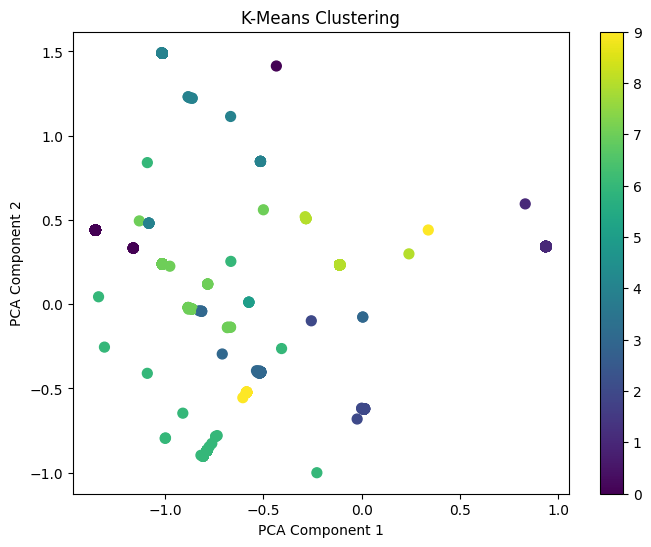

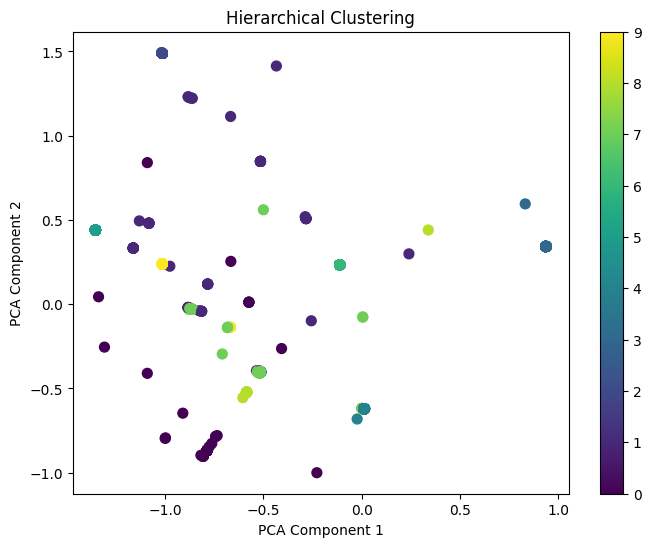

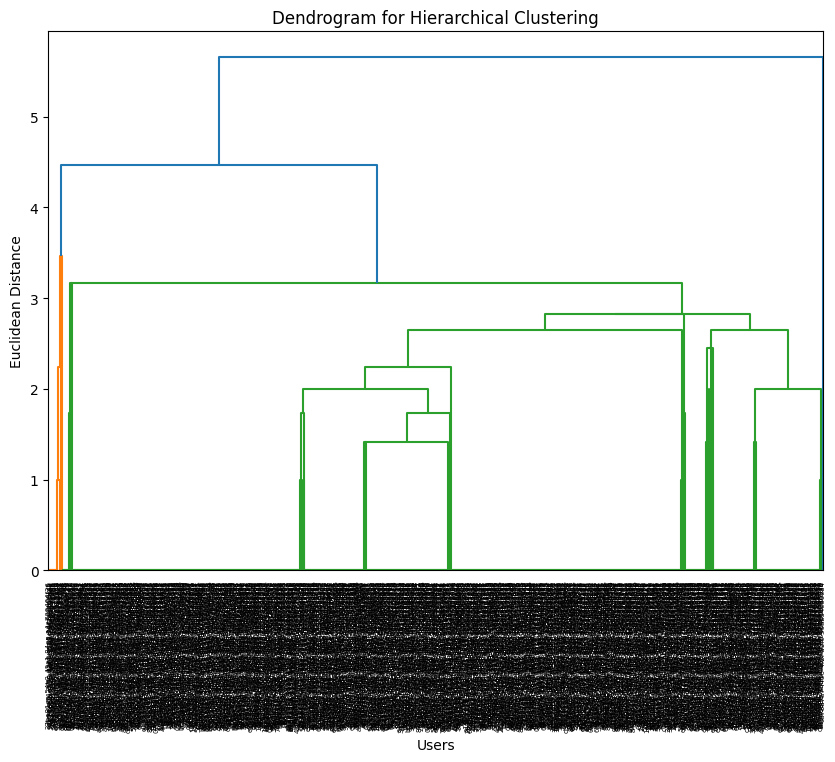

In [6]:
import sys
sys.path.insert(1, 'models')

from db_base import engine
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from connect import db_name

# Main pipeline execution
sql_query = f"""
    SELECT 
        urm.user_id,
        sr.name AS system_role_name
    FROM 
        {db_name}.user_roles_mapping urm
    JOIN 
        {db_name}.system_role_assignments sra ON urm.user_role_id = sra.user_role_id
    JOIN 
        {db_name}.system_roles sr ON sra.system_role_id = sr.id;
"""

def fetch_data(sql_query):
    """Fetch data from the database using the provided SQL query."""
    try:
        df = pd.read_sql(sql_query, engine)
        print("Data loaded successfully from the database.")
        return df
    except Exception as e:
        print("An error occurred while fetching data:", e)
        return None

def transform_to_binary_matrix(df):
    """Transform system roles into a binary access matrix."""
    binary_access_matrix = pd.get_dummies(df, columns=['system_role_name'], prefix='', prefix_sep='').groupby('user_id').max()
    return binary_access_matrix

def find_optimal_clusters(data, min_clusters=2, max_clusters=10):
    """Determine the optimal number of clusters using the silhouette score."""
    silhouette_scores = []
    highest_silhouette_score = -1
    optimal_n_clusters = min_clusters
    
    for n_clusters in range(min_clusters, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)

        if silhouette_avg > highest_silhouette_score:
            highest_silhouette_score = silhouette_avg
            optimal_n_clusters = n_clusters
            
    print(f"The optimal number of clusters is: {optimal_n_clusters} with a silhouette score of {highest_silhouette_score}")
    return optimal_n_clusters

def perform_clustering(data, n_clusters):
    """Run KMeans and Hierarchical clustering on the data."""
    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(data)

    # Hierarchical clustering
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
    hierarchical_labels = hierarchical.fit_predict(data)
    
    return kmeans_labels, hierarchical_labels

def plot_clusters(data, labels, title):
    """Plot clusters in 2D space using PCA for dimensionality reduction."""
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar()
    plt.show()

def plot_dendrogram(data, labels):
    """Generate a dendrogram for hierarchical clustering."""
    linked = linkage(data, method='complete')
    plt.figure(figsize=(10, 7))
    dendrogram(linked, orientation='top', labels=labels, distance_sort='descending', show_leaf_counts=False)
    plt.title("Dendrogram for Hierarchical Clustering")
    plt.xlabel("Users")
    plt.ylabel("Euclidean Distance")
    plt.show()

df = fetch_data(sql_query)
if df is not None:
    binary_access_matrix = transform_to_binary_matrix(df)
    optimal_cluster_count = find_optimal_clusters(binary_access_matrix)

    # Perform clustering
    kmeans_labels, hierarchical_labels = perform_clustering(binary_access_matrix, optimal_cluster_count)

    # Plot KMeans Clustering
    plot_clusters(binary_access_matrix, kmeans_labels, "K-Means Clustering")

    # Plot Hierarchical Clustering
    plot_clusters(binary_access_matrix, hierarchical_labels, "Hierarchical Clustering")

    # Plot Dendrogram
    subset_data = binary_access_matrix.sample(n=1000, random_state=42)  # Adjust sample size as needed
    plot_dendrogram(subset_data, subset_data.index.tolist())
